In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import nibabel as nib
import math
from statistics import mean 
from sksurgeryvtk.models.vtk_surface_model import VTKSurfaceModel
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from sksurgeryvtk.models.vtk_surface_model import VTKSurfaceModel



import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    print(f'added {module_path} to sys')
    sys.path.append(module_path)


from endosimutilities.end_utils import create_transform, \
                                  multiply_points_by_matrix, \
                                  multiply_point_by_matrix, pointer_to_mri,\
                                  camera_to_mri, mri_to_camera, add_noise_to_points,\
                                  add_noise_to_params, extract_rigid_body_parameters,\
                                  rigid_body_parameters_to_matrix, \
                                  convert_4x1_to_1x1x3, project_camera_point_to_image, \
                                  create_pnt_ref, create_pnt_ref_in_camera_space, create_pat_ref, \
                                  create_pat_ref_in_camera_space, get_ref_T_tip, calculate_euclid_dist, convert_points_nx3_to_1xnx3

In [3]:

def dispNiftiSlice(image_data, nii_header, dim, slice_ind, int_lims=None):
    """
    function to display a slice of a 3D nifti image

    SYNTAX:
    dispNiftiSlice(image_data, nii_header, dim, slice_ind)
    dispNiftiSlice(image_data, nii_header, dim, slice_ind, int_lims)

    INPUTS:
    image_data - a 3D numpy array containing the image data to display, e.g.
       as returned by the getfdata function of a nibabel.nifti1.Nifti1Image object
    nii_header - a nibabel.nifti1.Nifti1Header object
    dim - the dimension that the slice is taken from ('x', 'y', or 'z')
    slice_ind - the slice index to display (zero-indexing first slice = 0)
    int_lims - a two element vector with the min and max intensities to display
       default = [np.nanmin(CT_1.get_fdata()) np.nanmax(CT_1.get_fdata())]   
    """

    # check if intensity limits have been provided, and if not set to min and
    # max of image
    if not int_lims:
        int_lims = [np.nanmin(image_data), np.nanmax(image_data)]
        # check if min and max are same (i.e. all values in img are equal)
        if int_lims[0] == int_lims[1]:
            # add one to int_lims(2) and subtract one from int_lims(1), so that
            # int_lims(2) is larger than int_lims(1) as required by imagesc
            # function
            int_lims[0] -= 1
            int_lims[1] += 1

    # set slice to display to selected slice
    if dim == 'x':
        slice_to_disp = np.squeeze(image_data[slice_ind, :, :]).T
    elif dim == 'y':
        slice_to_disp = np.squeeze(image_data[:, slice_ind, :]).T
    elif dim == 'z':
        slice_to_disp = np.squeeze(image_data[:, :, slice_ind]).T
    else:
        raise ValueError('dim must be x, y, or z')

    # clear any previous plot from current axes
    plt.gca().clear()

    # use imshow to display selected slice. if dim is x or y then the y-axis
    # should increase as it moves up the screen, if dim is z then the y-axis
    # increases as move down the screen
    if dim == 'z':
        plt.imshow(slice_to_disp, cmap='gray', vmin=int_lims[0], vmax=int_lims[1], origin='upper')
    else:
        plt.imshow(slice_to_disp, cmap='gray', vmin=int_lims[0], vmax=int_lims[1], origin='lower')

    # scale axis to account for voxel size
    pix_dim = nii_header.get_zooms()
    if dim == 'x':
        plt.gca().set_aspect(pix_dim[2] / pix_dim[1])
    elif dim == 'y':
        plt.gca().set_aspect(pix_dim[2] / pix_dim[0])
    elif dim == 'z':
        plt.gca().set_aspect(pix_dim[1] / pix_dim[0])


In [5]:
phantom = nib.load('../phantom/images/transphenoidal_phantom.nii')
phantom_img = phantom.get_fdata()

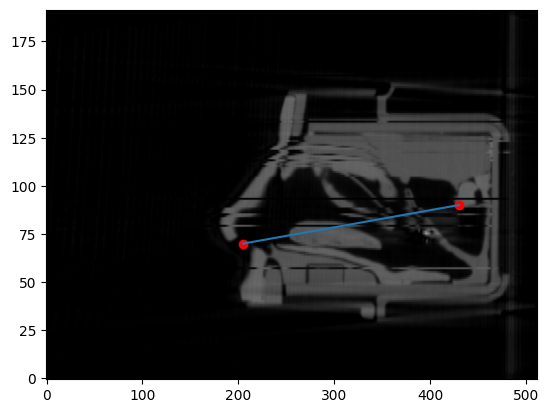

In [6]:
# line along X
dispNiftiSlice(phantom_img, phantom.header, 'x', 300)

nostrill = [300,205,70]
cancer = [290,430,90]

points = np.array([nostrill, cancer])

plt.scatter(points[:,1],points[:,2],c='r')
plt.plot(points[:,1],points[:,2])

Text(0, 0.5, 'y')

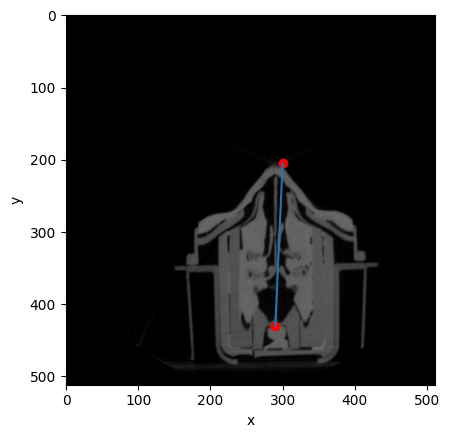

In [7]:
# line along Y

dispNiftiSlice(phantom_img, phantom.header, 'z', 100)
plt.scatter(points[:,0],points[:,1],c='r')
plt.plot(points[:,0],points[:,1])
plt.xlabel('x')
plt.ylabel('y')

# TAKING IMAGES

First we want to rotate it to make it sliceable in the direction of interest

calculate rotation along x


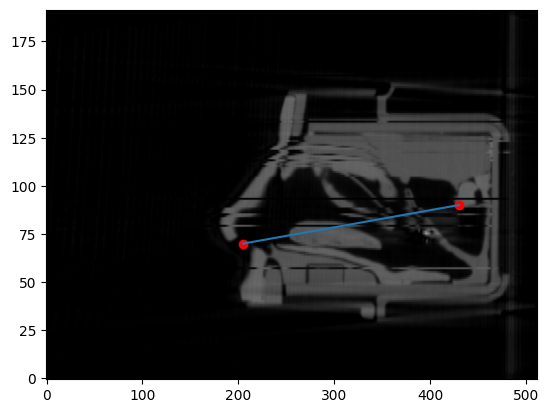

In [8]:
dispNiftiSlice(phantom_img, phantom.header, 'x', 300)
plt.scatter(points[:,1],points[:,2],c='r')
plt.plot(points[:,1],points[:,2])
plt.show()

In [9]:

z = points[:,2] 
y = points[:,1]
o_a = (z[1]-z[0])/(y[1]-y[0])
print(o_a)
angle_x = math.degrees(math.atan(o_a))
print(angle_x) # angle = (90-70)/(430-205)

0.08888888888888889
5.079607860014571


and now along Z

Text(0, 0.5, 'y')

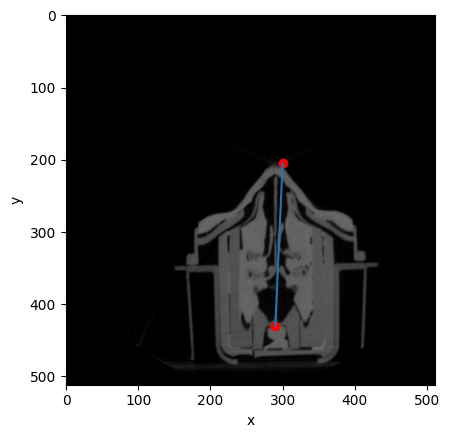

In [10]:
dispNiftiSlice(phantom_img, phantom.header, 'z', 100)
plt.scatter(points[:,0],points[:,1],c='r')
plt.plot(points[:,0],points[:,1])
plt.xlabel('x')
plt.ylabel('y')

In [11]:
x = points[:,0] 
y = points[:,1]
o_a = (x[1]-x[0])/(y[1]-y[0])
print(o_a)
angle_z = math.degrees(math.atan(o_a))
print(angle_z) # angle = (90-70)/(430-205)

-0.044444444444444446
-2.5448043798130957


Now composing the transform

In [12]:
T = create_transform([0,0,0,angle_x,math.degrees(0),angle_z])
T

array([[ 0.99901381,  0.04440061,  0.        ,  0.        ],
       [-0.04422624,  0.99509032, -0.08853979,  0.        ],
       [-0.00393122,  0.08845247,  0.99607264,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [13]:
phantom_img.shape

(512, 512, 192)

### SELECTING SLICE AT AN ANGLE NOW USING THOSE ROTATIONS

In [14]:
from scipy.interpolate import interpn


z = np.arange(0, phantom_img.shape[0])
y = np.arange(0, phantom_img.shape[1])
x = np.arange(0, phantom_img.shape[2])



II, JJ, KK = np.meshgrid(z , y, x, indexing='ij')
image_coordinates =  np.concatenate( (II.reshape(-1,1), JJ.reshape(-1,1), KK.reshape(-1,1), np.ones((np.prod(phantom_img.shape), 1))), axis=1).T

In [15]:
# defining coordinates to sample the gridded data at
xi = np.dot(T, image_coordinates)[:3].T


# specifying the coordinates of the grid
points_i = np.arange(0,phantom_img.shape[0])
points_j = np.arange(0, phantom_img.shape[1])
points_k = np.arange(0, phantom_img.shape[2])
points = (points_i, points_j, points_k)

# performing interpolation and reshaping to the original image shape
image_interpn_flatten = interpn(points, phantom_img, xi, bounds_error=False, fill_value=0)
image_trans = image_interpn_flatten.reshape(phantom_img.shape)



image_trans.shape


(512, 512, 192)

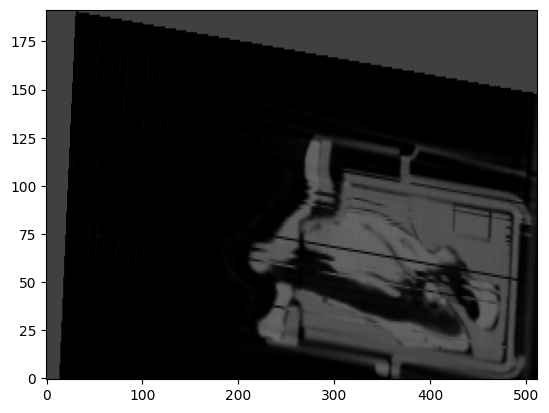

In [18]:
dispNiftiSlice(image_trans, phantom.header, 'x', 300)

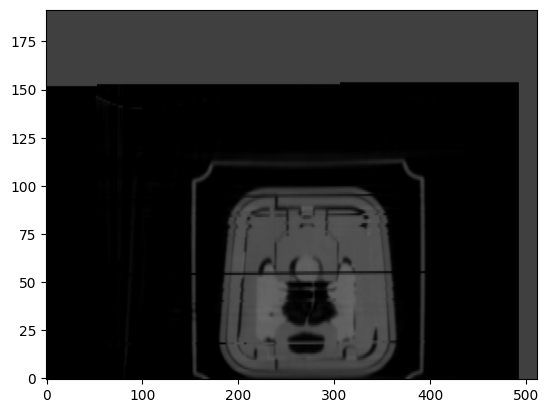

In [19]:
dispNiftiSlice(image_trans, phantom.header, 'y', 450)

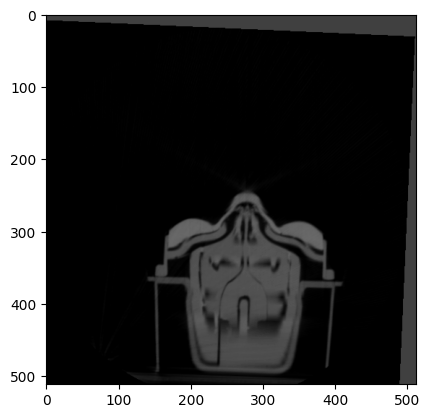

In [20]:




dispNiftiSlice(image_trans, phantom.header, 'z', 90)





# USING TRANSFORM OBTAINED FROM VTK

In [21]:

Transform = np.array([[0.996761, 0.049510, 0.063369, -122.931002],
                        [0.033279, 0.463408, -0.885520, -132.056007],
                        [-0.073207, 0.884761, 0.460259, -27.597528],
                        [0.000000, 0.000000, 0.000000, 1.000000]])

# defining coordinates to sample the gridded data at
xi = np.dot(Transform, image_coordinates)[:3].T

# performing interpolation and reshaping to the original image shape
image_interpn_flatten_matt = interpn(points, phantom_img, xi, bounds_error=False, fill_value=0)
image_trans_matt = image_interpn_flatten.reshape(phantom_img.shape)
                       
                       


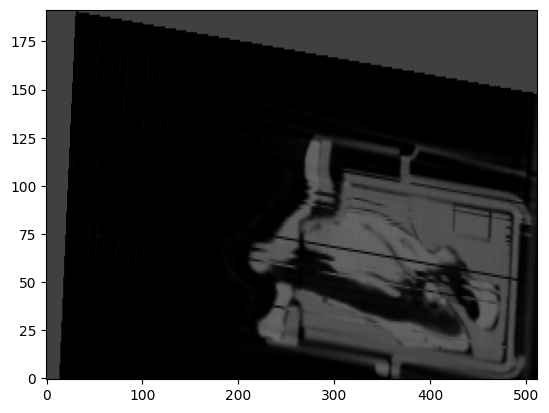

In [22]:
                       
dispNiftiSlice(image_trans_matt, phantom.header,'x', 300)

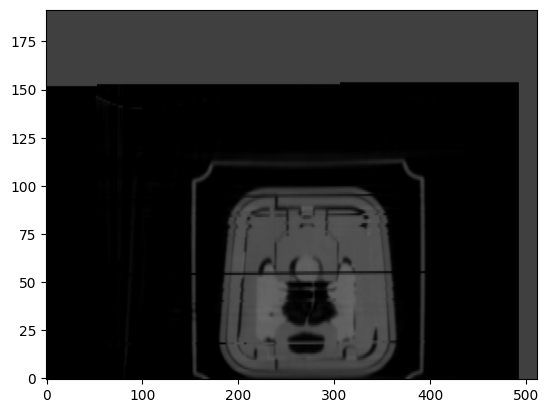

In [23]:
                       
dispNiftiSlice(image_trans_matt, phantom.header, 'y', 450)   

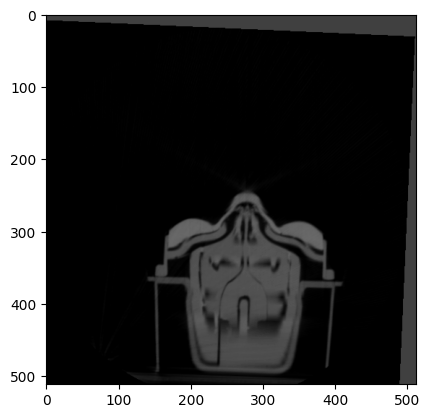

In [24]:
dispNiftiSlice(image_trans_matt, phantom.header,'z', 90)

Used by mistage instead of storz in phantom experiment, but keeping in here just in case I need it in future

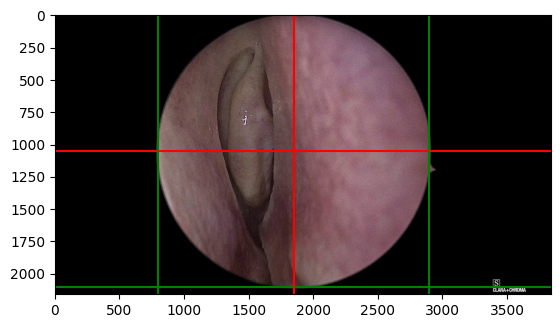

In [4]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# load endoscope image and convert to np array
endoscope_image = '../phantom/images/00000010.jpg'
image = Image.open(endoscope_image)
image = np.array(image)

plt.imshow(image)


# finding mid y position
low_y = 0
high_y = 2100
plt.axhline(y=low_y, color='g', linestyle='-')
plt.axhline(y=high_y, color='g', linestyle='-')

mid_y = (high_y-low_y)/2
plt.axhline(y=mid_y, color='r', linestyle='-')

low_x = 800
high_x = 2900
plt.axvline(x=low_x, color='g', linestyle='-')
plt.axvline(x=high_x, color='g', linestyle='-')

mid_x = (high_x-low_x)/2 +low_x
plt.axvline(x=mid_x, color='r', linestyle='-')

centre = [mid_x,mid_y]
radius = mid_x-low_x # could also be mid_y-low_y, or negative of mid_x-high_x or -ve of mid_y-high_y